Adapted from https://www.kaggle.com/duygut/airbnb-nyc-price-prediction

#**Introduction**

####Airbnb is one of the fastest growing online marketplace for lodgings. Madrid, the heart of Spain,has an average of ten million eager travelers flocking to the city yearly, all looking for accomodations for the duration of their travels.

####Uses of price prediction results include foreseeing expenses on the customer side. On the supply side, businesses can see areas that they can improve on to maximize their prices.

####By leveraging a dataset that contains lodging activities and metrics of Madrid, I would like to choose the best prediction model for price. 


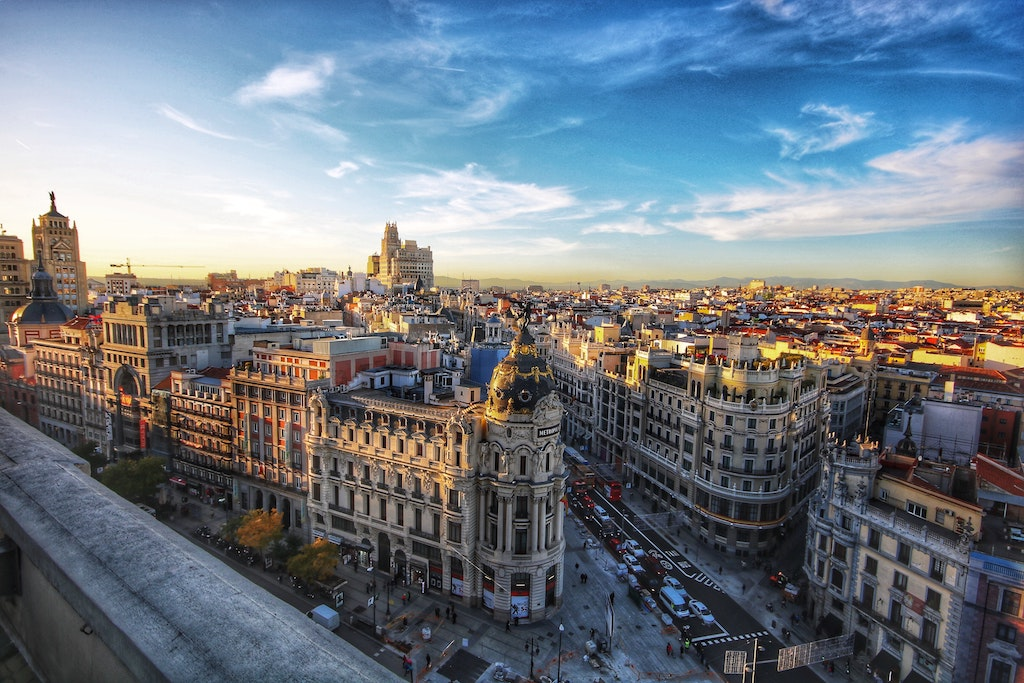



#**Importing Data**

In [ ]:
import pandas as pd
data = pd.read_csv("listings.csv", header = 0)
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,6369,"Rooftop terrace room with ensuite bathroom, Airc.",13660,Simon,Chamartín,Hispanoamérica,40.45628,-3.67763,Private room,70,1,65,2019-09-04,0.56,1,53
1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40341,-3.74084,Private room,17,4,33,2018-07-15,0.55,2,48
2,24805,Gran Via Studio Madrid,101471,Iraido,Centro,Universidad,40.42202,-3.70395,Entire home/apt,80,5,2,2017-07-03,0.03,1,354
3,24836,"Select the Madrid more ""cool"".",101653,Tenty,Centro,Justicia,40.41995,-3.69764,Entire home/apt,115,3,64,2019-07-07,0.63,1,301
4,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38985,-3.69011,Private room,25,2,136,2019-07-10,1.19,1,337


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20837 entries, 0 to 20836
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20837 non-null  int64  
 1   name                            20832 non-null  object 
 2   host_id                         20837 non-null  int64  
 3   host_name                       20822 non-null  object 
 4   neighbourhood_group             20837 non-null  object 
 5   neighbourhood                   20837 non-null  object 
 6   latitude                        20837 non-null  float64
 7   longitude                       20837 non-null  float64
 8   room_type                       20837 non-null  object 
 9   price                           20837 non-null  int64  
 10  minimum_nights                  20837 non-null  int64  
 11  number_of_reviews               20837 non-null  int64  
 12  last_review                     

# Exploratory Data Analysis

In [ ]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [ ]:
#Since we are predicting the price, we will first examine the relationship of price with each feature separately

###**Room Type against Price based on Neighborhood Group**

### The accomodations with the highest price in every category are all located in Centro.

Text(0.5, 1.0, 'Room Type/Price/Neighbourhood Group')

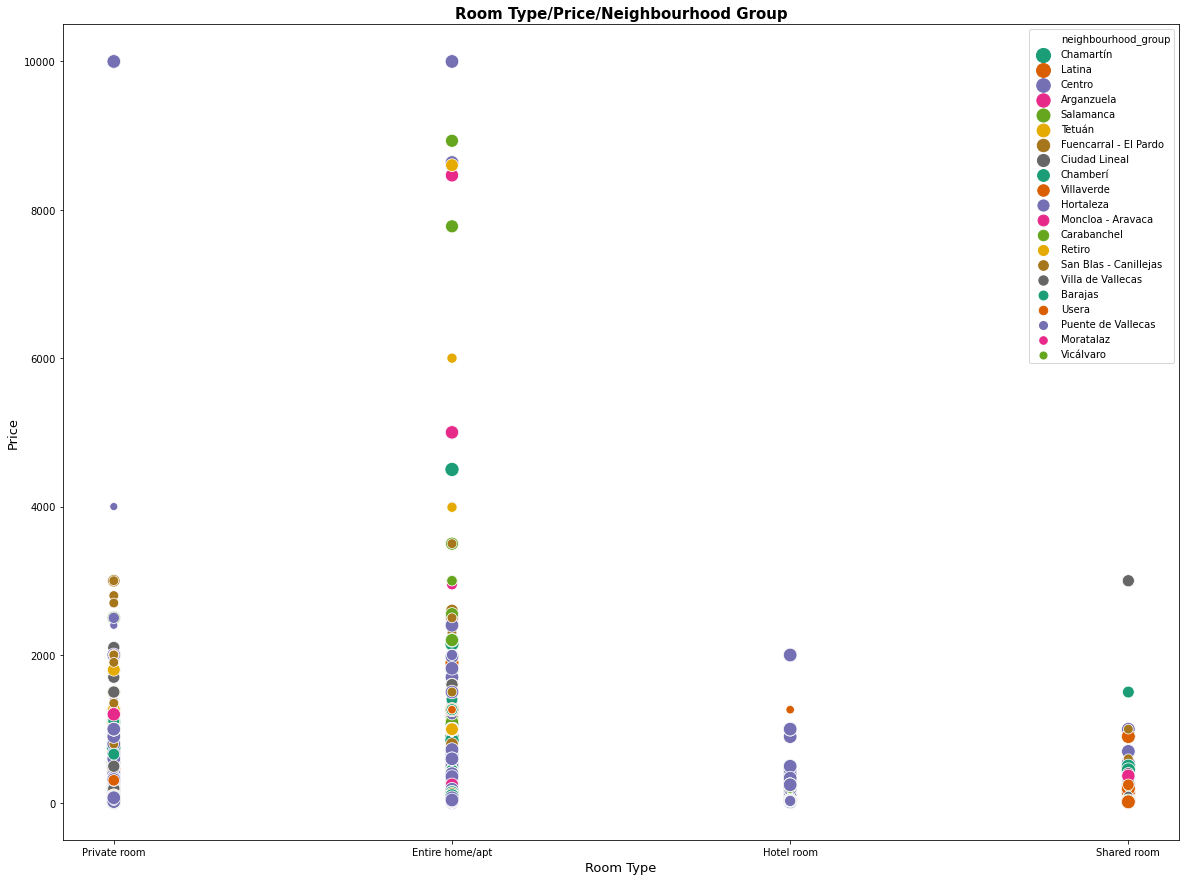

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="Dark2", data=data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type/Price/Neighbourhood Group",size=15, weight='bold')

###**Price against Number of Reviews based on Neighborhood Group**

###Negative correlation between price and the number of reviews, the lower the price, the higher the number of reviews.

Text(0.5, 1.0, 'Price/Number of Reviews/Neighbourhood Group')

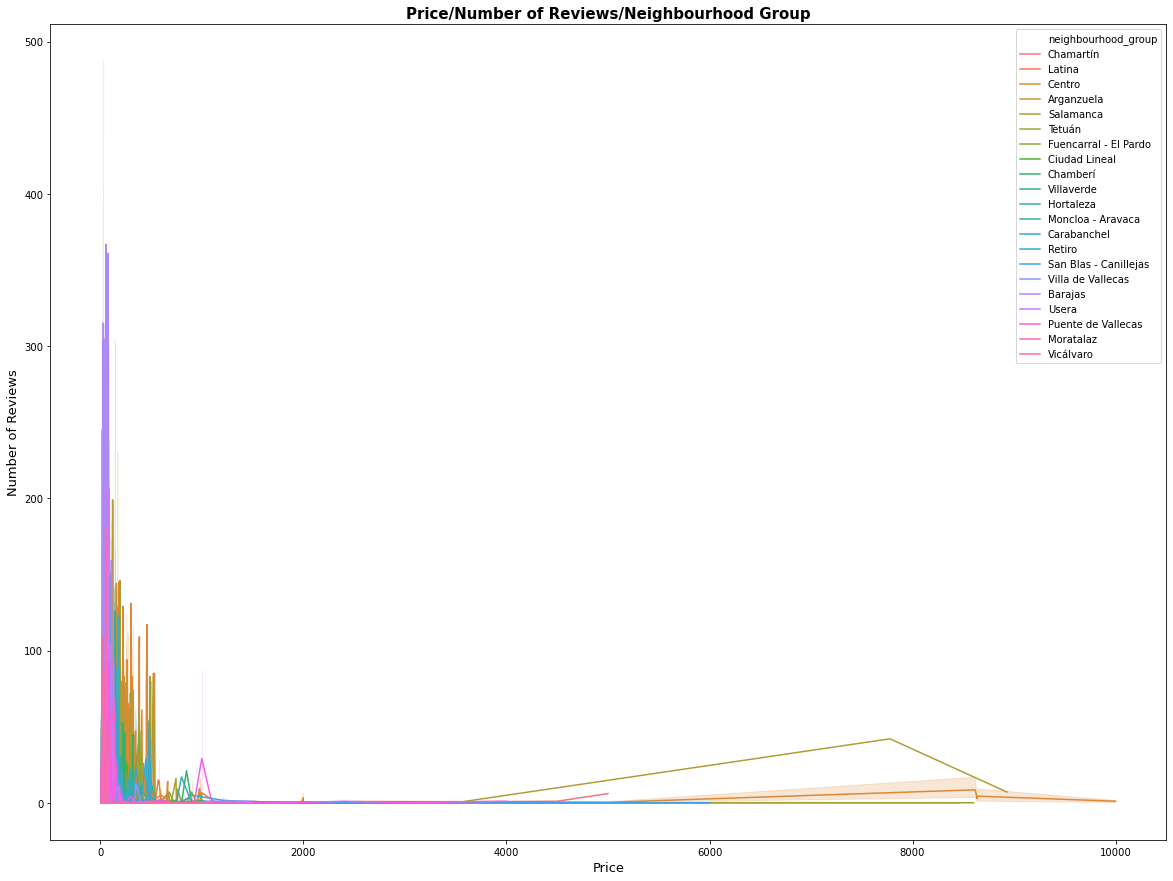

In [ ]:
plt.figure(figsize=(20, 15))
sns.set_palette("Set1")
sns.lineplot(data=data, x="price", y="number_of_reviews", hue="neighbourhood_group")
plt.xlabel("Price", size=13)
plt.ylabel("Number of Reviews", size=13)
plt.title("Price/Number of Reviews/Neighbourhood Group",size=15, weight='bold')

# Data Preprocessing

###**Categorical Variables**

In [ ]:
data['neighbourhood_group']= data['neighbourhood_group'].astype("category").cat.codes
data['neighbourhood'] = data['neighbourhood'].astype("category").cat.codes
data['room_type'] = data['room_type'].astype("category").cat.codes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20837 entries, 0 to 20836
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20837 non-null  int64  
 1   name                            20832 non-null  object 
 2   host_id                         20837 non-null  int64  
 3   host_name                       20822 non-null  object 
 4   neighbourhood_group             20837 non-null  int8   
 5   neighbourhood                   20837 non-null  int16  
 6   latitude                        20837 non-null  float64
 7   longitude                       20837 non-null  float64
 8   room_type                       20837 non-null  int8   
 9   price                           20837 non-null  int64  
 10  minimum_nights                  20837 non-null  int64  
 11  number_of_reviews               20837 non-null  int64  
 12  last_review                     

###**Price Distribution**

###Since the data is right skewed and also contains zero values, we have to normalize it with log(x+1) transformation.

Text(0.5, 1.0, 'Price Distribution Plot')

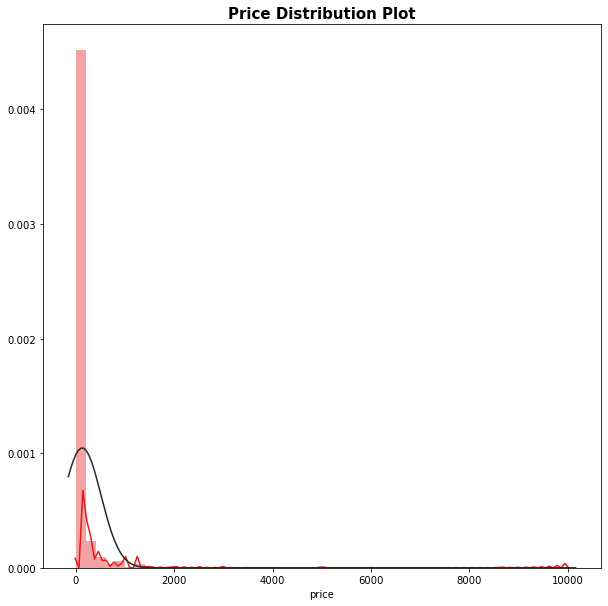

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(data['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

Text(0.5, 1.0, 'Log-Price Distribution Plot')

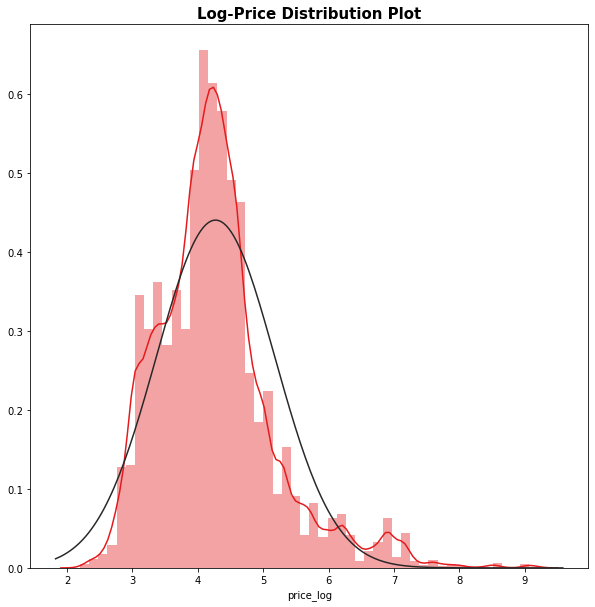

In [ ]:
data['price_log'] = np.log(data.price+1)
plt.figure(figsize=(10,10))
sns.distplot(data['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

###**Treating Missing Values**

In [ ]:
data_model = data.drop(columns=['name','id' ,'host_id','host_name', 
                                   'last_review','price'])
data_model.isnull().sum()

neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 4654
calculated_host_listings_count       0
availability_365                     0
price_log                            0
dtype: int64

In [ ]:
#Replace missing values in number_of_reviews column with mean

mean = data_model['reviews_per_month'].mean()
data_model['reviews_per_month'].fillna(mean, inplace=True)
data_model.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
price_log                         0
dtype: int64

###**Correlation**

###No strong relationship between price and any other variables.

Text(0.5, 1.0, 'Correlation Matrix')

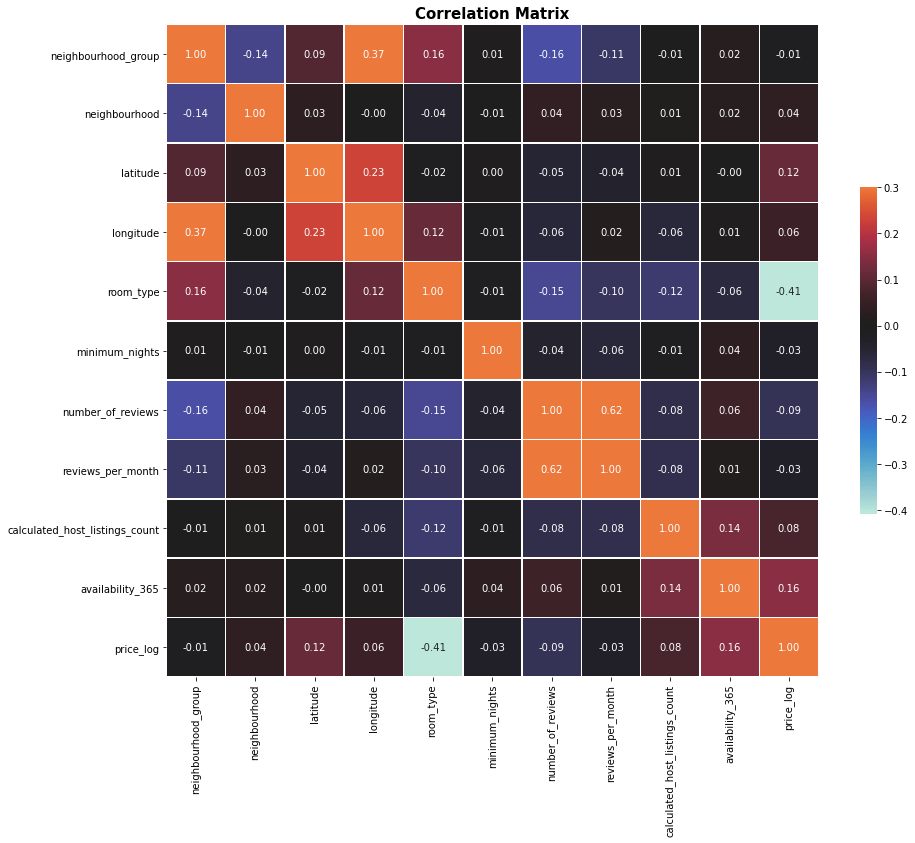

In [ ]:
plt.figure(figsize=(15,12))
corr=data_model.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

###**Residuals**

###The charts show the residual plot of each predictor against price. Ideally the blue line should be horizontal however the charts show that most of the features are non-linear, and underfitting may occur when fitting a linear model on non-linear data, or when over-regularized. To combat this problem, we can reduce regularization weight, perform feature selection or add new features.Since new features cannot be added for this kernel, feature selection and regularized linear models will be used instead.

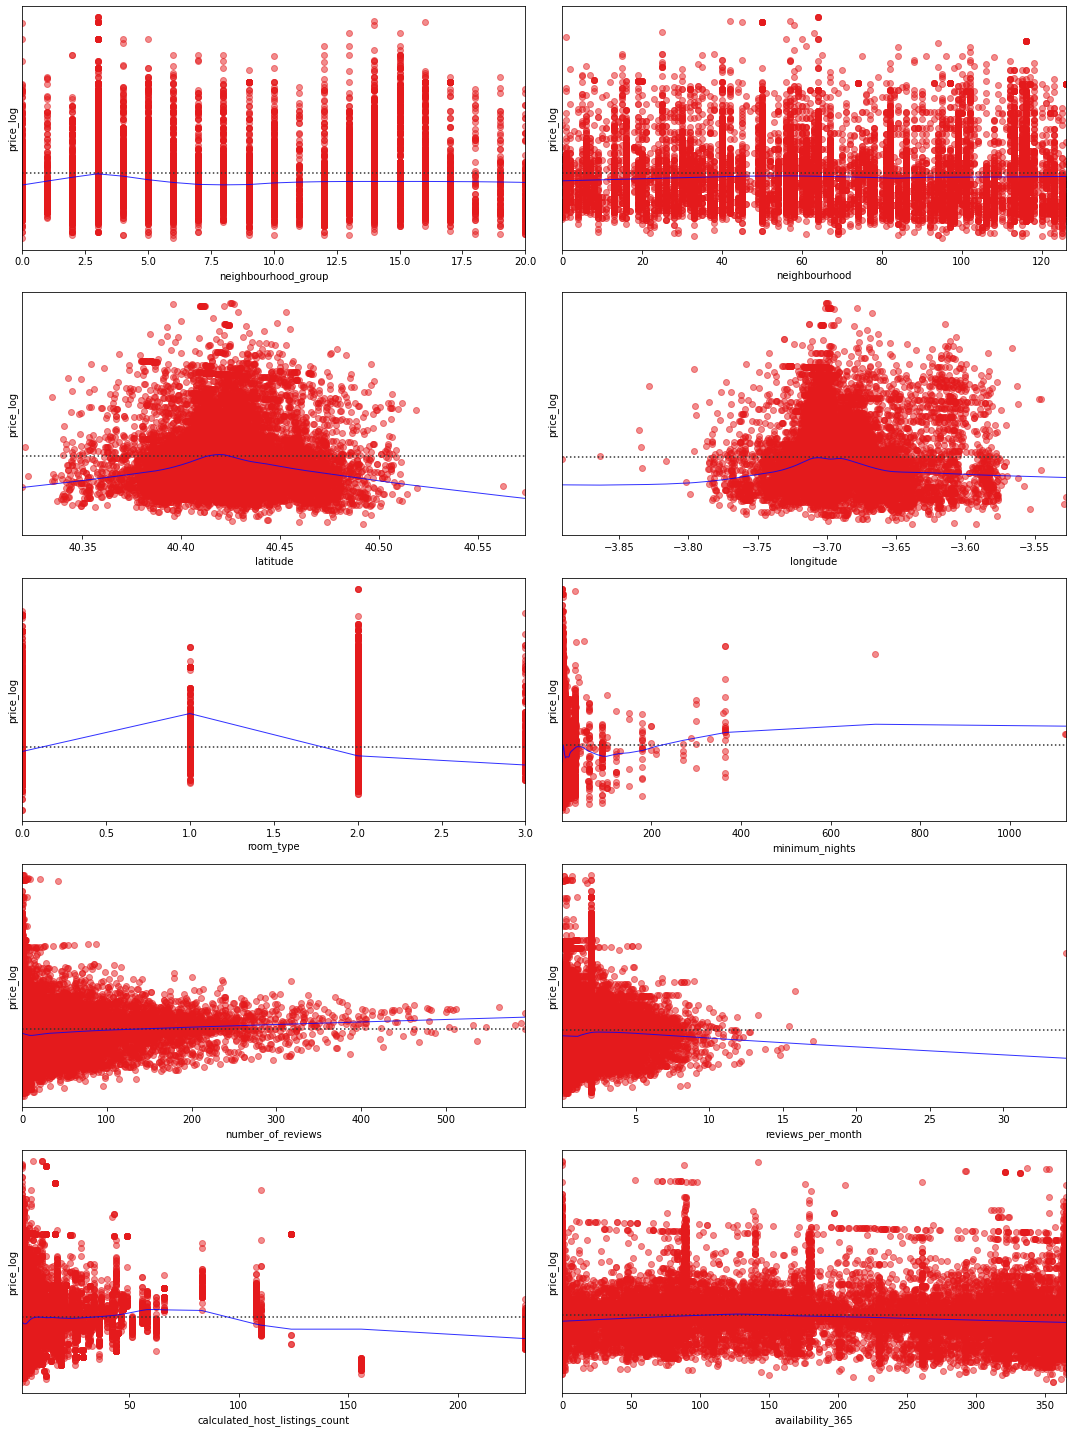

In [ ]:
#Split the dataset into features and label.
data_model_x, data_model_y = data_model.iloc[:,:-1], data_model.iloc[:,-1]


f, axes = plt.subplots(5, 2, figsize=(15, 20))
sns.residplot(data_model_x.iloc[:,0],data_model_y, lowess=True, ax=axes[0, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,1],data_model_y, lowess=True, ax=axes[0, 1],
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,2],data_model_y, lowess=True, ax=axes[1, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,3],data_model_y, lowess=True, ax=axes[1, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,4],data_model_y, lowess=True, ax=axes[2, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,5],data_model_y, lowess=True, ax=axes[2, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,6],data_model_y, lowess=True, ax=axes[3, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,7],data_model_y, lowess=True, ax=axes[3, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,8],data_model_y, lowess=True, ax=axes[4, 0], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
sns.residplot(data_model_x.iloc[:,9],data_model_y, lowess=True, ax=axes[4, 1], 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'blue', 'lw': 1, 'alpha': 0.8})
plt.setp(axes, yticks=[])
plt.tight_layout()

In [ ]:
# The charts show the residual plot of each predictor against price.
# Ideally the blue line should be horizontal however the charts show that most of the features are non-linear,
# and underfitting may occur when fitting a linear model on non-linear data, or when over-regularized.
# To combat this problem, we can reduce regularization weight, perform feature selection or add new features.
# Since new features cannot be added for this kernel, feature selection and regularized linear models will be used
# instead.

###**Multicollinearity**

###Multicollinearity measures the relationship between explanatory variables in multiple regression. Redundant variables must be removed to ensure accuracy of the model.

###Since no values are close to zero, multicollinearity does not exist.

In [ ]:
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([1.83469506, 1.54219706, 1.41133422, 0.35454693, 0.52155073,
       0.5755595 , 0.80953175, 0.87305057, 1.07175557, 1.0138664 ,
       0.99191222])

In [ ]:
#Split the dataset into features and label.

data_model_x, data_model_y = data_model.iloc[:,:-1], data_model.iloc[:,-1]


###**Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_model_x, data_model_y, test_size=0.3,random_state=42)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train) #chain multiple estimators to one
X_test = pipeline.transform(X_test)

###**Ranking Importance of Features**

###All models will be built in two phases. The first phase will include all of the features while the second phase will not include the three least important features: room type, neighbourhood group and neighbourhood, as shown by the graph.

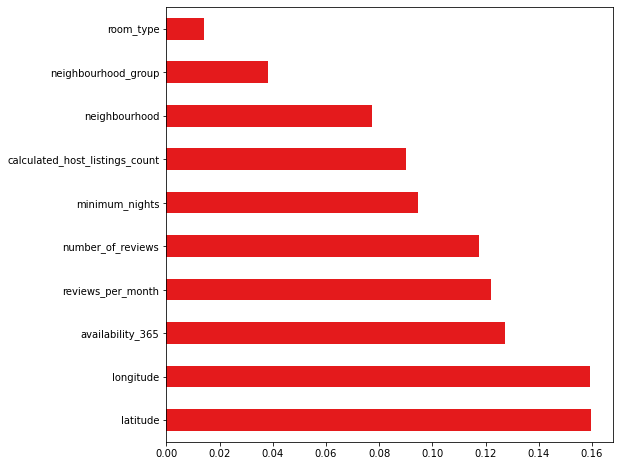

In [ ]:
# Use extra tree classifier to build a feature importance graph

le = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,le.fit_transform(y_train))

plt.figure(figsize=(8,8))
feature_importances = pd.Series(feature_model.feature_importances_, index=data_model.iloc[:,:-1].columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

#**Model Building**

## Phase 1

#####Bar chart comparing R^2 values, which measures the goodness of fit, of each model.
#####These models arent performing too great.
#####Low difference between RMSE of test and train set of all models supports the earlier diagnosis that underfitting has occured.


#####Eliminate models that have negative R2 and cross validation scores as this shows that the models fit worse than a horizontal line, and is counterproductive when fitted on new data. 


#####The poorest performing model is Elastic Net Regression, with not only a negative R2, but also that of the highest magnitude

#####Out of the remaining models, although Polynomial Regression has the highest R2 and lowest MAE, MSE, RMSE, it has a cross validation score of 0, which shows that it is not effective at all when used on new data, as evidenced by an increase in MSE and RMSE, and the reduction of R2 of the test set from the train set. Moving on, the model with the second lowest MSE, RMSE and second highest R2 also has the highest cross validation score. Therefore, the best fit model of phase 1 is Ridge Regression.


In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# The cross_val_score calculates the R squared metric for the applied model. 
def cross_val(model):
    pred = cross_val_score(model, data_model_x, data_model_y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [ ]:
### Linear Regression ###


from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(normalize=True)

In [ ]:
pred_lr= lin_reg.predict(X_test)

In [ ]:
test_pred_lr = lin_reg.predict(X_test)
train_pred_lr = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_lr)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_lr)

Test set evaluation:
_____________________________________
MAE: 0.5526390015840303
MSE: 0.6088621626128672
RMSE: 0.7802962018444453
R2 0.2195529039833347
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.561310955547644
MSE: 0.6435269906115346
RMSE: 0.8022013404448628
R2 0.23292034014900342
__________________________________


In [ ]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred_lr) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656


In [ ]:
from sklearn.linear_model import RANSACRegressor

model_ran = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
model_ran.fit(X_train, y_train)

test_pred_ran = model_ran.predict(X_test)
train_pred_ran = model_ran.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_ran)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_ran)

Test set evaluation:
_____________________________________
MAE: 0.7134823901917197
MSE: 1.0407575400588498
RMSE: 1.0201752496796077
R2 -0.33405596483556543
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.7241260967953153
MSE: 1.0734481386682528
RMSE: 1.03607342339636
R2 -0.27954265336228445
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred_ran) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206


In [ ]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model_ridge.fit(X_train, y_train)
pred_ridge = model_ridge.predict(X_test)

test_pred_ridge = model_ridge.predict(X_test)
train_pred_ridge = model_ridge.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_ridge)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_ridge)

Test set evaluation:
_____________________________________
MAE: 0.5524841073662479
MSE: 0.6087389396737154
RMSE: 0.7802172387698925
R2 0.2197108526799838
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5611933171085397
MSE: 0.6435392504367927
RMSE: 0.8022089817727004
R2 0.23290572652327213
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred_ridge) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206
2,Ridge Regression,0.552484,0.608739,0.780217,0.219711,0.189747


In [ ]:
from sklearn.linear_model import Lasso

model_las = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model_las.fit(X_train, y_train)

test_pred_las = model_las.predict(X_test)
train_pred_las = model_las.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_las)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_las)

Test set evaluation:
_____________________________________
MAE: 0.6462389516326287
MSE: 0.7683717076623306
RMSE: 0.8765681420530469
R2 0.01509158438586966
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6594155374921099
MSE: 0.8259623375980653
RMSE: 0.9088247012477517
R2 0.015458685932695948
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred_las) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206
2,Ridge Regression,0.552484,0.608739,0.780217,0.219711,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999


In [ ]:
from sklearn.linear_model import ElasticNet

model_enet = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model_enet.fit(X_train, y_train)

test_pred_enet = model_enet.predict(X_test)
train_pred_enet = model_enet.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_enet)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_enet)

Test set evaluation:
_____________________________________
MAE: 0.5650426260465234
MSE: 0.6429585595963478
RMSE: 0.8018469676916836
R2 0.17584771807361588
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.573614215440832
MSE: 0.6856565133646625
RMSE: 0.8280437871058888
R2 0.18270224447527883
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_pred_enet) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206
2,Ridge Regression,0.552484,0.608739,0.780217,0.219711,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.565043,0.642959,0.801847,0.175848,-0.037144


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d,y_train)

test_pred_poly = lin_reg.predict(X_test_2_d)
train_pred_poly = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_poly)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_poly)

Test set evaluation:
_____________________________________
MAE: 0.5281627822161125
MSE: 0.5928936060514528
RMSE: 0.7699958480741651
R2 0.2400215984780817
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5332866397802886
MSE: 0.5767183779094517
RMSE: 0.7594197639707908
R2 0.3125557379711381
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred_enet), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206
2,Ridge Regression,0.552484,0.608739,0.780217,0.219711,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.565043,0.642959,0.801847,0.175848,-0.037144
5,Polynomail Regression,0.565043,0.642959,0.801847,0.175848,0.000000


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred_sgd = sgd_reg.predict(X_test)
train_pred_sgd = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_sgd)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_sgd)

Test set evaluation:
_____________________________________
MAE: 0.5525750915195222
MSE: 0.6088731676494767
RMSE: 0.7803032536453226
R2 0.21953879759047468
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5612500081218534
MSE: 0.6435276481499921
RMSE: 0.8022017502785643
R2 0.23291955636777328
__________________________________


In [ ]:
results_df_2 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred_sgd), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'Cross Validation'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.552639,0.608862,0.780296,0.219553,0.188656
1,Robust Regression,0.713482,1.040758,1.020175,-0.334056,-3.422206
2,Ridge Regression,0.552484,0.608739,0.780217,0.219711,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.565043,0.642959,0.801847,0.175848,-0.037144
5,Polynomail Regression,0.565043,0.642959,0.801847,0.175848,0.000000
6,Stochastic Gradient Descent,0.552575,0.608873,0.780303,0.219539,0.000000


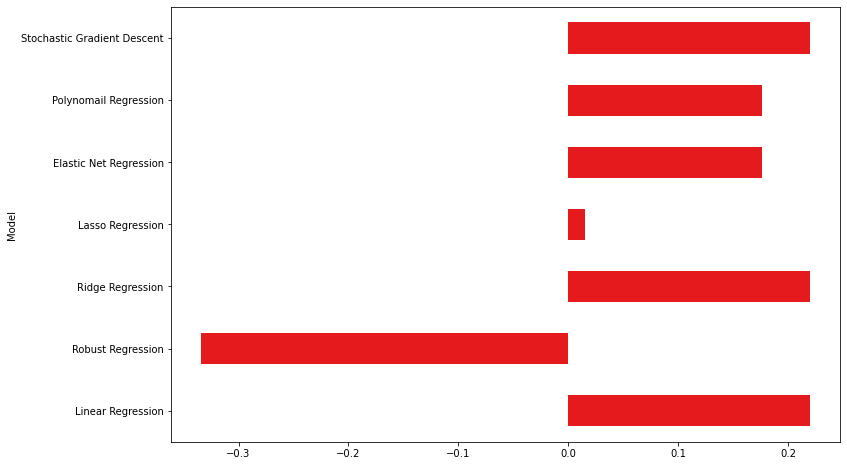

In [ ]:
results_df.set_index('Model', inplace=True)
results_df['R2'].plot(kind='barh', figsize=(12, 8))

In [ ]:
# Low difference between RMSE of test and train set of all models
# supports the earlier diagnosis that underfitting has occured. //low variance, high bias 


# Eliminate models that have negative R2 and cross validation scores as this shows that the models fit worse than a 
# horizontal line, and is counterproductive when fitted on new data. 

# The poorest performing model is Elastic Net Regression, with not only a negative R2, but also that of the 
# highest magnitude


# Out of the remaining models, 
# although Polynomial Regression has the highest R2 and lowest MAE, MSE, RMSE, it has a cross validation score of 0
# which shows that it is not effective at all when used on new data, 
# as evidenced by an increase in MSE and RMSE, and the reduction of R2 of the test set from the train set. 
# Moving on, the model with the second lowest MSE, RMSE and second highest R2 
# also has the highest cross validation score.
# Therefore, the best fit model of phase 1 is Ridge Regression.



## Phase 2

In [ ]:
data_model_xx= data_model.drop(columns=['neighbourhood_group', 'room_type', 'neighbourhood'])
data_model_xx.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
0,40.45628,-3.67763,1,65,0.56,1,53,4.262680
1,40.40341,-3.74084,4,33,0.55,2,48,2.890372
2,40.42202,-3.70395,5,2,0.03,1,354,4.394449
3,40.41995,-3.69764,3,64,0.63,1,301,4.753590
4,40.38985,-3.69011,2,136,1.19,1,337,3.258097


In [ ]:
data_model_xx, data_model_yx = data_model_xx.iloc[:,:-1], data_model_xx.iloc[:,-1]
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(data_model_xx, data_model_yx, test_size=0.3,random_state=42)

In [ ]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train_x = pipeline.fit_transform(X_train_x) #chain multiple estimators to one
X_test_x = pipeline.transform(X_test_x)

In [ ]:
### Linear Regression ###


from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_x,y_train_x)
pred_lr_x= lin_reg.predict(X_test_x)

test_pred_lr_x = lin_reg.predict(X_test_x)
train_pred_lr_x = lin_reg.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_lr_x)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_lr_x)

Test set evaluation:
_____________________________________
MAE: 0.6433288980866813
MSE: 0.7406851326837552
RMSE: 0.8606306598557567
R2 0.05058058069325855
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6554537782818933
MSE: 0.7931963916472614
RMSE: 0.89061573736784
R2 0.054515463723405544
__________________________________


In [ ]:
results_df1 = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test_x, test_pred_lr_x) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656


In [ ]:
from sklearn.linear_model import RANSACRegressor

model_ran_x = RANSACRegressor(base_estimator=LinearRegression(), max_trials=100)
model_ran_x.fit(X_train_x, y_train_x)

test_pred_ran_x = model_ran_x.predict(X_test_x)
train_pred_ran_x = model_ran_x.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_ran_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_ran_x)

Test set evaluation:
_____________________________________
MAE: 0.7961844765829825
MSE: 1.4686505088416237
RMSE: 1.2118789167411173
R2 -0.8825344964286013
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8245973603212602
MSE: 1.5775716191527138
RMSE: 1.256014179518971
R2 -0.8804543067576496
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test_x, test_pred_ran_x) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592


In [ ]:
from sklearn.linear_model import Ridge

model_ridge_x = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model_ridge_x.fit(X_train_x, y_train_x)
pred_ridge_x = model_ridge_x.predict(X_test_x)

test_pred_ridge_x = model_ridge_x.predict(X_test_x)
train_pred_ridge_x = model_ridge_x.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_ridge_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_ridge_x)

Test set evaluation:
_____________________________________
MAE: 0.6431889782108883
MSE: 0.7406844218653015
RMSE: 0.8606302468919516
R2 0.050581491829197134
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6553147096624645
MSE: 0.7931994283463281
RMSE: 0.89061744219745
R2 0.05451184399941389
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test_x, test_pred_ridge_x) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592
2,Ridge Regression,0.643189,0.740684,0.860630,0.050581,0.189747


In [ ]:
from sklearn.linear_model import Lasso

model_las_x = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model_las_x.fit(X_train_x, y_train_x)

test_pred_las_x = model_las_x.predict(X_test_x)
train_pred_las_x = model_las_x.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_las_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_las_x)

Test set evaluation:
_____________________________________
MAE: 0.6462388699280236
MSE: 0.7683715051398479
RMSE: 0.8765680265329371
R2 0.015091843981708042
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6594154471029732
MSE: 0.825962118094229
RMSE: 0.9088245804852711
R2 0.01545894757972932
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test_x, test_pred_las_x) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592
2,Ridge Regression,0.643189,0.740684,0.860630,0.050581,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999


In [ ]:
from sklearn.linear_model import ElasticNet

model_enet_x = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
model_enet_x.fit(X_train_x, y_train_x)

test_pred_enet_x = model_enet_x.predict(X_test_x)
train_pred_enet_x = model_enet_x.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_enet_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_enet_x)

Test set evaluation:
_____________________________________
MAE: 0.6450003609963606
MSE: 0.7651799233306881
RMSE: 0.8747456335019272
R2 0.019182853257057153
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6580238875230993
MSE: 0.8222774747643914
RMSE: 0.9067951669282271
R2 0.019851016589046533
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test_x, test_pred_enet_x) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "Cross Validation"])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592
2,Ridge Regression,0.643189,0.740684,0.860630,0.050581,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.645000,0.765180,0.874746,0.019183,-0.037144


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d_x = poly_reg.fit_transform(X_train_x)
X_test_2_d_x = poly_reg.transform(X_test_x)

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train_2_d_x,y_train_x)

test_pred_poly_x = lin_reg.predict(X_test_2_d_x)
train_pred_poly_x = lin_reg.predict(X_train_2_d_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_poly_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_poly_x)

Test set evaluation:
_____________________________________
MAE: 0.6244008066897639
MSE: 0.7459814554152628
RMSE: 0.8637021798138886
R2 0.04379168831467206
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6314745116755132
MSE: 0.7318808660152004
RMSE: 0.8555003600321863
R2 0.1276031402802672
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred_enet_x), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'Cross Validation'])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592
2,Ridge Regression,0.643189,0.740684,0.860630,0.050581,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.645000,0.765180,0.874746,0.019183,-0.037144
5,Polynomail Regression,0.645000,0.765180,0.874746,0.019183,0.000000


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg_x = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg_x.fit(X_train_x, y_train_x)

test_pred_sgd_x = sgd_reg_x.predict(X_test_x)
train_pred_sgd_x = sgd_reg_x.predict(X_train_x)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_x, test_pred_sgd_x)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_x, train_pred_sgd_x)

Test set evaluation:
_____________________________________
MAE: 0.6432974769306786
MSE: 0.7407033758752077
RMSE: 0.8606412585248326
R2 0.050557196343457345
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.6554163902148522
MSE: 0.793196721556132
RMSE: 0.8906159225817445
R2 0.05451507047434545
__________________________________


In [ ]:
results_df_21 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test_x, test_pred_sgd_x), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', 'Cross Validation'])
results_df1 = results_df1.append(results_df_21, ignore_index=True)
results_df1

,Model,MAE,MSE,RMSE,R2,Cross Validation
0,Linear Regression,0.643329,0.740685,0.860631,0.050581,0.188656
1,Robust Regression,0.796184,1.468651,1.211879,-0.882534,-6.898592
2,Ridge Regression,0.643189,0.740684,0.860630,0.050581,0.189747
3,Lasso Regression,0.646239,0.768372,0.876568,0.015092,-0.035999
4,Elastic Net Regression,0.645000,0.765180,0.874746,0.019183,-0.037144
5,Polynomail Regression,0.645000,0.765180,0.874746,0.019183,0.000000
6,Stochastic Gradient Descent,0.643297,0.740703,0.860641,0.050557,0.000000


#**Results**

#####Ideally it should be a y=x function, none of these are any close.
#####All the models suffer from heteroskedasticity, which means the variability of a variable is unequal across the range of values, suggested by the cone shape of all these charts.
#####Common cause is autocorrelation between residuals in a time series, but our independent variables are not, and the heat map during the data preprocessing stage also showed no correlation. So the most plausible problem is that the statistical significance of our variables may have been overstated. 
#####In conclusion, our models might not be completely accurate, but through this project we encountered many common issues and learnt how to overcome it.


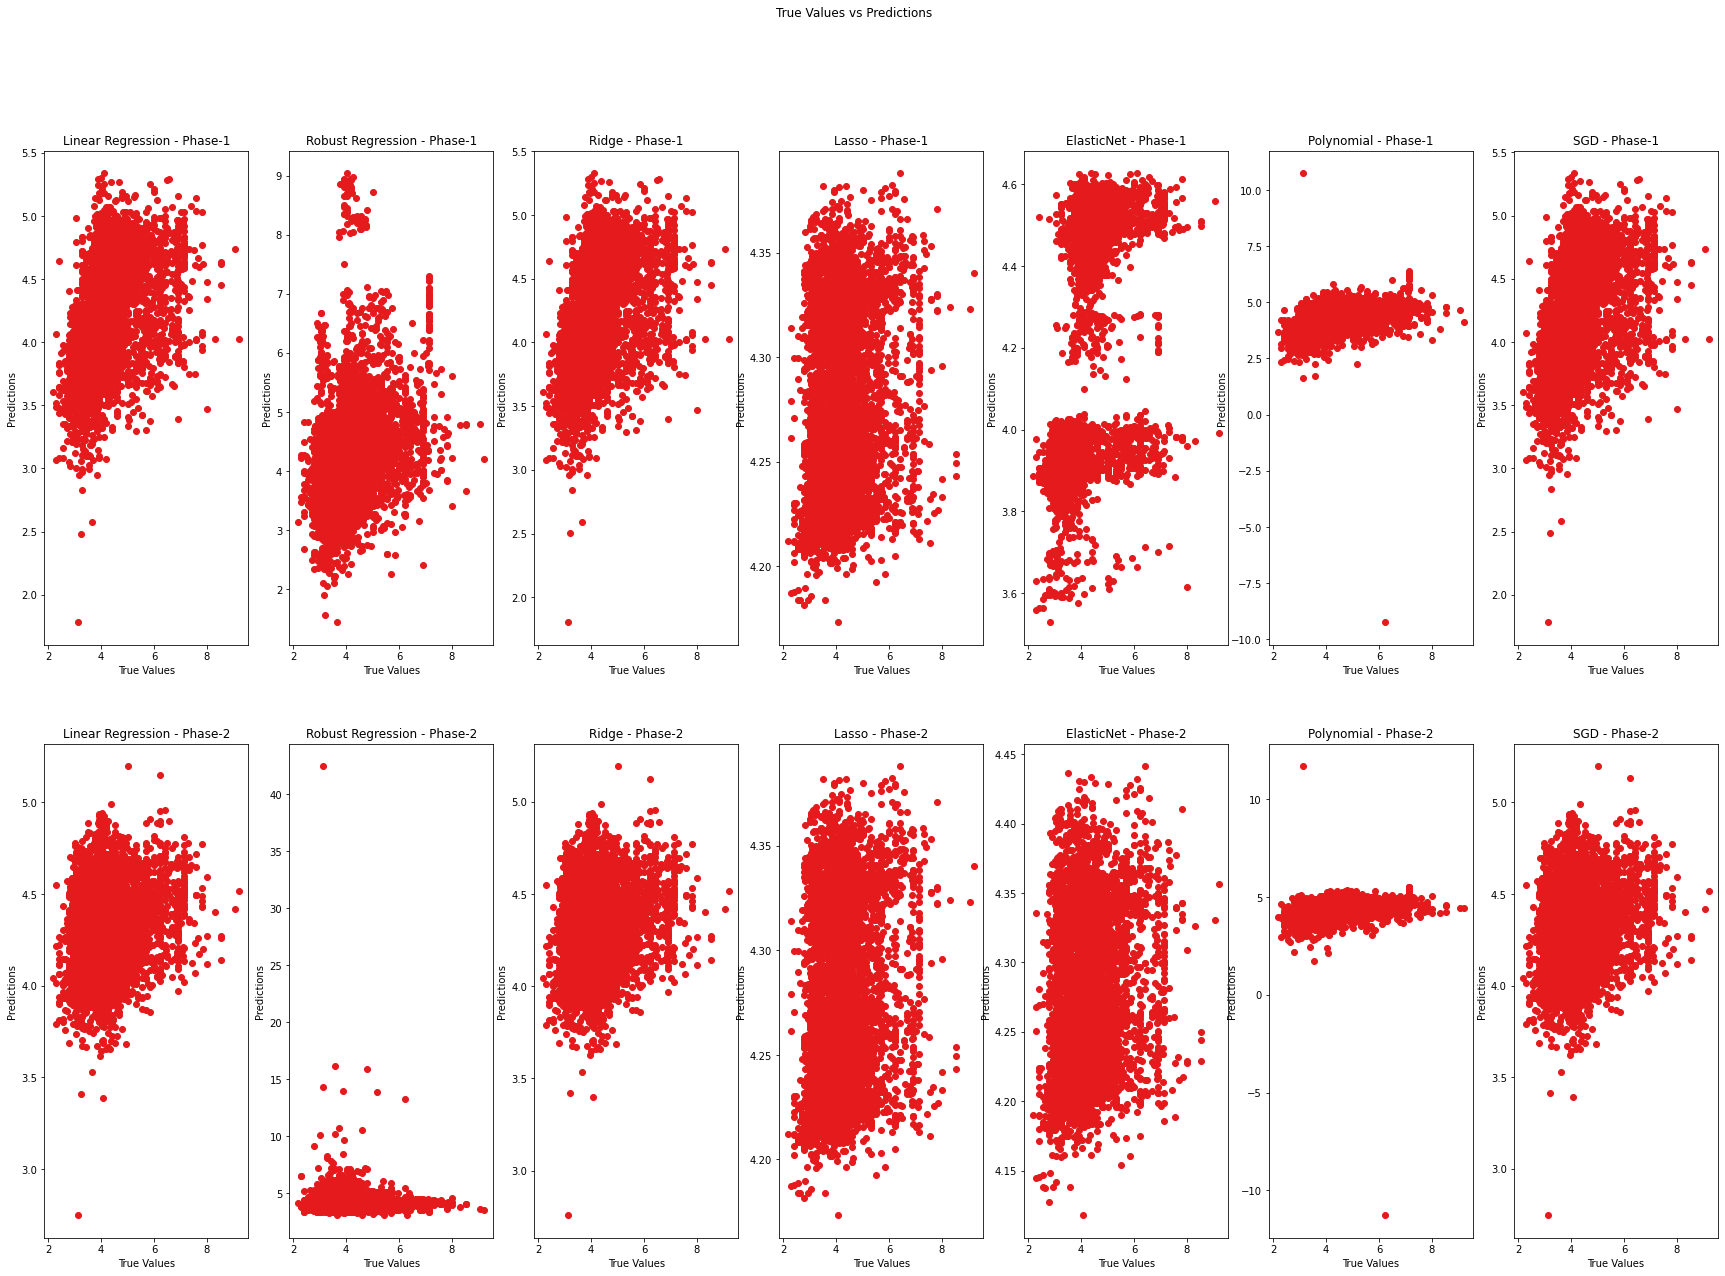

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, figsize=(30, 20))
fig.suptitle('True Values vs Predictions')

ax1.scatter(y_test, test_pred_lr)
ax1.set_title('Linear Regression - Phase-1')

ax2.scatter(y_test, test_pred_ran)
ax2.set_title('Robust Regression - Phase-1')

ax3.scatter(y_test, test_pred_ridge)
ax3.set_title('Ridge - Phase-1')

ax4.scatter(y_test, test_pred_las)
ax4.set_title('Lasso - Phase-1')

ax5.scatter(y_test, test_pred_enet)
ax5.set_title('ElasticNet - Phase-1')

ax6.scatter(y_test, test_pred_poly)
ax6.set_title('Polynomial - Phase-1')

ax7.scatter(y_test, test_pred_sgd)
ax7.set_title('SGD - Phase-1')

ax8.scatter(y_test_x, test_pred_lr_x)
ax8.set_title('Linear Regression - Phase-2')

ax9.scatter(y_test_x, test_pred_ran_x)
ax9.set_title('Robust Regression - Phase-2')

ax10.scatter(y_test_x, test_pred_ridge_x)
ax10.set_title('Ridge - Phase-2')

ax11.scatter(y_test_x, test_pred_las_x)
ax11.set_title('Lasso - Phase-2')

ax12.scatter(y_test_x, test_pred_enet_x)
ax12.set_title('ElasticNet - Phase-2')

ax13.scatter(y_test_x, test_pred_poly_x)
ax13.set_title('Polynomial - Phase-2')

ax14.scatter(y_test_x, test_pred_sgd_x)
ax14.set_title('SGD - Phase-2')







for ax in fig.get_axes():
    ax.set(xlabel='True Values', ylabel='Predictions')